In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, lars_path
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from collections import defaultdict

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read KS data collected in January
# ks_df = pd.read_csv('./kickstarter_data/01.csv', index_col=0)
# relevant_categories = ['design/product design', 'fashion/apparel', 'fashion/accessories', 'fashion', 'technology/gadgets', 'fashion/footwear', 'fashion/ready-to-wear', 'art/textiles', 'fashion/childrenswear', 'fashion/couture', 'technology/wearables']
# relevant_df = ks_df[ks_df.category.isin(relevant_categories)]

In [3]:
# Read Amzn Data
amz_df = pd.read_csv('./amazon_data/Duffel.csv')
amz_df_tt = pd.read_csv('./amazon_data/TravelTote.csv')
amz_df_luggage = pd.read_csv('./amazon_data/Luggage.csv')

In [4]:
new_df = pd.concat([amz_df, amz_df_tt, amz_df_luggage], ignore_index=True)

In [82]:
new_df.head()

,Brand,Name,Url,Rating,review_count,1Star,2Star,3Star,4Star,5Star,...,days_since_launch,styles,weight_ounces,volume_dimensions,volume,volume_unit,min_price,max_price,amazon_rank,rank_category
0,NaN,Herschel Supply Co. Novel Duffle Bag,NaN,4.2,751,75.10,52.57,67.59,112.65,443.09,...,4560.0,"[Black Grid, Black/Black, Black/Blueprint/Wh...",34.4,11 x 20.5 x 11.5 inches,2593.25,inches,65.00,NaN,2442.0,Clothing Shoes & Jewelry
1,Ledmark,Ledmark Heavyweight Cotton Canvas Outback Duff...,NaN,4.6,684,20.52,20.52,27.36,123.12,492.48,...,NaN,"[Green, Black]",NaN,NaN,NaN,NaN,25.99,149.99,1807.0,Sports & Outdoors
2,NaN,Olympia USA 33 Inch 8 Pocket Rolling Duffel,NaN,3.7,1158,173.70,81.06,92.64,185.28,625.32,...,141.0,"[Black, Black w/ Beige - Exclusive Color, Ch...",107.2,NaN,NaN,NaN,42.99,NaN,2324.0,Clothing Shoes & Jewelry
3,NaN,"Olympia Luggage 22"" 8 Pocket Rolling Duffel Bag",NaN,4.3,1621,97.26,81.05,129.68,307.99,1005.02,...,5070.0,"[Black, Black / Gray, Black w/ Beige - Exclu...",78.4,12 x 12 x 22 inches,3168.00,inches,27.97,NaN,1131.0,Clothing Shoes & Jewelry
4,Plambag,Plambag Unisex's Canvas Duffel Bag Oversized T...,NaN,4.3,739,36.95,44.34,44.34,103.46,509.91,...,NaN,"[Grey, Army Green, Coffee, Dark Grey]",48.0,NaN,NaN,NaN,29.99,NaN,1169.0,Sports & Outdoors


In [84]:
new_df.shape

(13038, 22)

In [6]:
def extract_rating(input_string):
    if pd.isnull(input_string):
        return 0
    else:
        rating = float(input_string[0:3])
        return rating

In [7]:
new_df['Rating'] = new_df['Star Rating'].apply(extract_rating)

In [8]:
def extract_review_count(input_string):
    if pd.isnull(input_string):
        return 0
    else:
        pattern = re.compile('(\d*)\s')
        review_count = int(re.search(pattern, input_string).group(1))
        return review_count

new_df['review_count'] = new_df['Review Count'].apply(extract_review_count)

In [9]:
def convert_stars(input_string):
    if pd.isnull(input_string):
        return 0
    else:
        pattern = re.compile('(\d*)\%')
        percent_string = re.search(pattern, input_string).group(1)
        percent_decimal = int(percent_string)/100
        return percent_decimal
    
new_df['1Star'] = new_df['1 Stars'].apply(convert_stars)*new_df['review_count']
new_df['2Star'] = new_df['2 Stars'].apply(convert_stars)*new_df['review_count']
new_df['3Star'] = new_df['3 Stars'].apply(convert_stars)*new_df['review_count']
new_df['4Star'] = new_df['4 Stars'].apply(convert_stars)*new_df['review_count']
new_df['5Star'] = new_df['5 Stars'].apply(convert_stars)*new_df['review_count']

In [10]:
def count_styles(input_string):
    if pd.isnull(input_string):
        return 1
    else:
        style_count = len(input_string.split(';'))
        return style_count
        

In [11]:
new_df['style_count'] = new_df['Styles'].apply(count_styles)

In [12]:
def convert_to_dict(input_string):
    if pd.isnull(input_string):
        return np.nan
    else:
        details = {}
        list_details = [ l.split(':') for l in input_string.split(';')]
#         print(list_details)
        for detail_pair in list_details:
            if len(detail_pair) == 2:
                details[detail_pair[0].strip()] = detail_pair[1].strip()
        return details

In [13]:
# Combine the rows where value = NaN
new_df['prod_details'] = new_df[['Product Details', 'Product Details Alt']].applymap(lambda x: '' if pd.isnull(x) else x ).apply(lambda x: x[0] + x[1], axis=1)

In [14]:
new_df['prod_details'] = new_df['prod_details'].map(convert_to_dict)

In [15]:
# Create dictionary to track all product detail categories
d = defaultdict(int)

for detail_dict in new_df['prod_details']:
    if pd.isnull(detail_dict):
        next
    else:
        for ke in detail_dict:
            d[ke] += 1

In [85]:
sorted_keys = sorted(d, key=lambda x: d[x], reverse=True)
for k in sorted_keys[:50]:
    print (k, d[k])

ASIN 12987
Average Customer Review 12252
Amazon Best Sellers Rank 11916
Date first available at Amazon.com 11715
Shipping Weight 11481
Item model number 9643
Product Dimensions 8290
Package Dimensions 2197
Domestic Shipping 1595
International Shipping 1595
Shipping Information 1438
Customer Reviews 735
Best Sellers Rank 674
Item Weight 669
California residents 647
Manufacturer 347
Department 148
Date First Available 94
Shipping Advisory 64
Manufacturer recommended age 55
Color 49
Manufacturer Part Number 46
 45
UPC 40
Brand 34
Part Number 31
Size 31
Item Package Quantity 30
Batteries Required? 24
Discontinued by manufacturer 21
Batteries Included? 19
Brand Name 19
Model 17
Folding 15
Material 10
Batteries 9
Style 8
Warranty Description 7
Special Features 7
Item Dimensions L x W x H 7
Material Type 5
Number of Items 4
Vehicle Service Type 4
Number of Handles 3
Handle 2
Weight 2
OEM Part Number 2
Series 2
Shipping 2
Assembled Height 2


In [17]:
def get_asin(details_dict):
    if pd.isnull(details_dict):
        asin = np.nan
    else:
        try:
            asin = details_dict['ASIN']
        except:
            asin = np.nan
#     print(asin)
    return asin

In [18]:
new_df['asin'] = new_df['prod_details'].map(get_asin)

In [19]:
def get_rank(details_dict):
    if pd.isnull(details_dict):
        ranking = np.nan
    else:
        try:
            ranking = details_dict['Amazon Best Sellers Rank']
        except:
            try:
                ranking = details_dict['Best Sellers Rank']
            except:
                ranking = np.nan
#     print(ranking)
    return ranking

new_df['amazon_ranking'] = new_df['prod_details'].map(get_rank)

In [20]:
# get date launch
def get_date(details_dict):
    if pd.isnull(details_dict):
        date = np.nan
    else:
        try:
            date = details_dict['Date first available at Amazon.com']
            date = pd.to_datetime(date)
        except:
            date = np.nan
    return date

new_df['date_launch'] = new_df['prod_details'].map(get_date)
new_df['days_since_launch'] = (pd.to_datetime('today') - new_df['date_launch']).map(lambda x: x.days)

In [21]:
# Convert styles to list
new_df['styles'] = new_df['Styles'].str.split(';')

In [22]:
# Extract weight
def get_weight(details_dict):
    if pd.isnull(details_dict):
        weight = np.nan
    else:
        try:
            weight_string = details_dict['Shipping Weight'].strip()
            weight_list = weight_string.split('(')[0].split(' ')
            if weight_list[1] == 'pounds':
                weight = float(weight_list[0]) * 16
            elif weight_list[1] == 'ounces':
                weight = float(weight_list[0])
            else:
                weight = np.nan
                print(weight_list)
        except:
            weight = np.nan
#         print(weight)
    return weight



In [23]:
new_df['weight_ounces'] = new_df['prod_details'].map(get_weight)

In [24]:
def get_volume(details_dict):
    volume_unit = np.nan
    volume_string = np.nan
    if pd.isnull(details_dict):
        volume = np.nan
    else:
        try:
            if details_dict['Product Dimensions']:
                volume_string = details_dict['Product Dimensions']
#             elif details_dict['Package Dimensions']:
#                 volume_string = details_dict['Package Dimensions']
            volume_list = volume_string.split('x')
            last_unit = volume_list[-1]
            [volume_list[-1], volume_unit] = last_unit.strip().split(' ')
            volume_list = [float(num.strip()) for num in volume_list]
            volume = np.prod(volume_list)
        except:
            volume = np.nan
    return volume_string, volume, volume_unit, 

In [25]:
volume_results = pd.DataFrame(list(new_df['prod_details'].map(get_volume)))

In [26]:
new_df['volume_dimensions'], new_df['volume'], new_df['volume_unit']= volume_results[0], volume_results[1], volume_results[2]

In [27]:
# Verify that all volumes are in inches
new_df[(new_df['volume_unit'].notnull()) & (new_df['volume_unit'] != 'inches')].shape

(0, 32)

In [28]:
def get_min_max_price(input_str):
    if pd.isnull(input_str):
        min_price, max_price = np.nan, np.nan
    else:
        min_price, max_price = np.nan, np.nan
        prices = input_str.split('-')
        if len(prices) >= 1:
            min_price = float(prices[0])
        if len(prices) >= 2:
            max_price = float(prices[1])
#     if pd.isnull(min_price):
#         print(input_str)
    return min_price, max_price

In [29]:
price_results = pd.DataFrame(list(new_df['Price'].map(get_min_max_price)))

In [30]:
new_df['min_price'], new_df['max_price'] = price_results[0], price_results[1]

In [31]:
def get_first_ranking(string):
    if pd.isnull(string):
        rank = np.nan
        category = np.nan
    else:
        try:
            first_ranking = string.split('(')[0].split(' ')
            rank = int(first_ranking[0].replace('#', ''))
            category = (' ').join(first_ranking[2:]).strip()
#             print(rank, category)
        except:
            rank = np.nan
            category = np.nan
    return rank, category

In [32]:
rankings_results = pd.DataFrame(list(new_df['amazon_ranking'].map(get_first_ranking)))

In [33]:
new_df['amazon_rank'], new_df['rank_category'] = rankings_results[0], rankings_results[1]

In [34]:
new_df.drop(['Price', '1 Stars', '2 Stars', '3 Stars', '4 Stars', '5 Stars', 'Product Details', 'Product Details Alt', 'Star Rating', 'Review Count', 'amazon_ranking', 'Styles', 'date_launch', 'prod_details', ], axis=1, inplace=True)

In [35]:
df = new_df[new_df['rank_category'] == 'Clothing Shoes & Jewelry'].reset_index()

In [36]:
print('before dropping null targets', df.shape)
# Drop all rows where amazon_rank does not exist
df = df[pd.notnull(df['amazon_rank'])]
print('after dropping null targets', df.shape)

before dropping null targets (11029, 23)
after dropping null targets (11029, 23)


In [86]:
# Set inverse rank
# df['inverse_rank'] = 21112839 - df['amazon_rank']

In [90]:
df.shape

(11029, 23)

In [38]:
# Check how many NaN in each column
df.isnull().sum()

index                    0
Brand                 3743
Name                     1
Url                   3379
Rating                   0
review_count             0
1Star                    0
2Star                    0
3Star                    0
4Star                    0
5Star                    0
style_count              0
asin                     0
days_since_launch        2
styles                5330
weight_ounces         1331
volume_dimensions     3983
volume                3983
volume_unit           3983
min_price              570
max_price            10696
amazon_rank              0
rank_category            0
dtype: int64

In [39]:
# Create new df with no unnecessary columns; Volume units are all inches, so it doesn't matter
df_vol = df.drop(['index', 'Brand', 'Name', 'Url', 'styles', 'volume_dimensions', 'rank_category', 'asin', 'volume_unit', 'max_price'], axis=1).copy()

# Create alternate df with no volume because too many NaN
df_novol = df_vol.drop(['volume'], axis=1).copy()

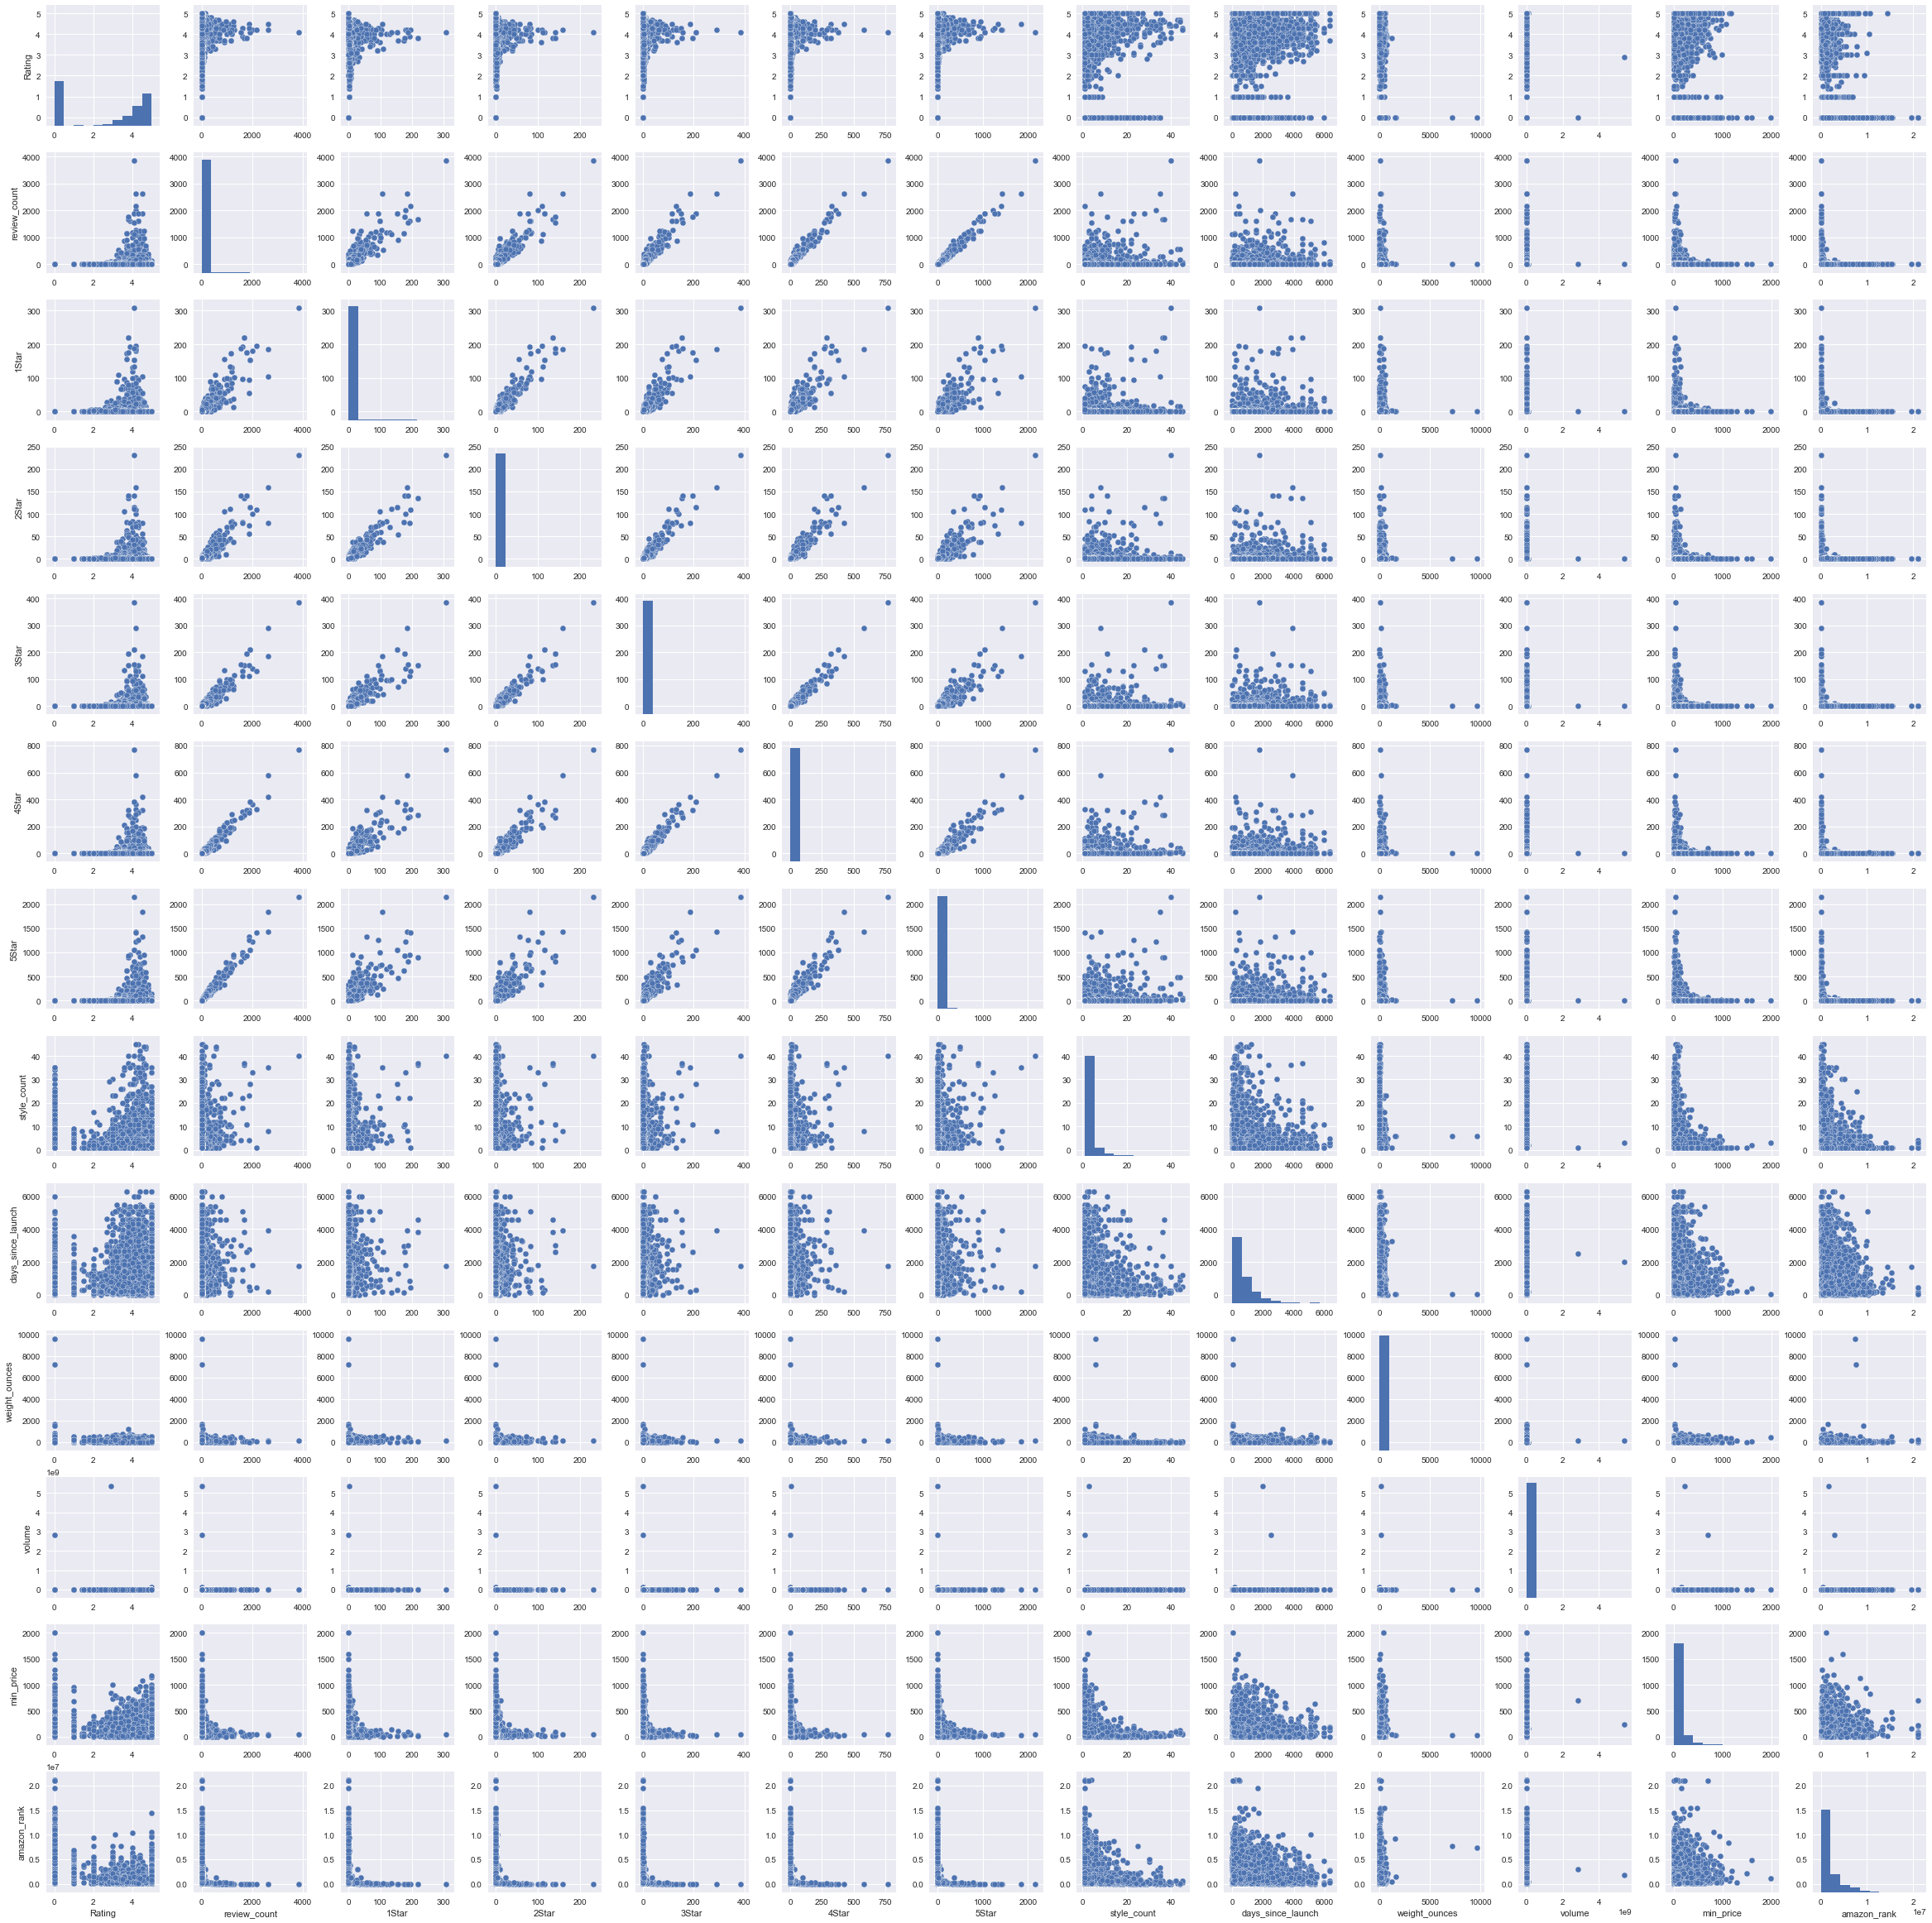

In [40]:
# Will not run with NaN values, so filling dummy with 0
sns.pairplot(df_vol.fillna(0))

In [41]:
# Drop all rows with NaN values
df_vol = df_vol.dropna()
df_novol = df_novol.dropna()

In [42]:
df_vol.columns

Index(['Rating', 'review_count', '1Star', '2Star', '3Star', '4Star', '5Star',
       'style_count', 'days_since_launch', 'weight_ounces', 'volume',
       'min_price', 'amazon_rank'],
      dtype='object')

In [48]:
# sns.jointplot('1Star', 'amazon_rank', data=df)
# sns.jointplot('2Star', 'amazon_rank', data=df)
# sns.jointplot('3Star', 'amazon_rank', data=df)
# sns.jointplot('4Star', 'amazon_rank', data=df)
# sns.jointplot('5Star', 'amazon_rank', data=df)
# sns.jointplot('Rating', 'amazon_rank', data=df)


In [80]:
df_novol.shape

(9303, 12)

In [81]:
df_vol.shape

(6719, 13)

In [50]:
# df.corr()

In [51]:
X=df_vol.loc[:,['Rating', 'review_count', '1Star', '2Star', '3Star', '4Star', '5Star',
       'style_count', 'days_since_launch', 'weight_ounces', 'volume',
       'min_price']]

y=df_vol['amazon_rank']

model = sm.OLS(y,sm.add_constant(X), missing="drop")
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amazon_rank   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     182.5
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        00:01:33   Log-Likelihood:            -1.0572e+05
No. Observations:                6719   AIC:                         2.115e+05
Df Residuals:                    6707   BIC:                         2.116e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               2.72e+06   4.53e+04     60.001      0.000    2.63e+06    2.81e+06
Rating             -4.14e+05   1.04e+04    -39.665      0.000   -4.34e+05   -3.94e+05
review_count       -813.3622   1122.214     -0.725      0.469   -3013.258    1386.534
1Star             -1697.1618   6928.619     -0.245      0.807   -1.53e+04    1.19e+04
2Star             -1.294e+04   1.32e+04     -0.984      0.325   -3.87e+04    1.28e+04
3Star              7917.2986      1e+04      0.788      0.431   -1.18e+04    2.76e+04
4Star              9307.5861   6262.372      1.486      0.137   -2968.652    2.16e+04
5Star             -3398.4186   1495.658     -2.272      0.023   -6330.383    -466.454
style_count       -3.433e+04   5478.485     -6.267      0.000   -4.51e+04   -2.36e+04
days_since_launch   219.6688     23.111      9.505      0.000     174.364     264.973
weight_ounces      -519.9775    114.045     -4.559      0.000    -743.542    -296.414
volume            -5.438e-06      0.000     -0.020      0.984      -0.001       0.001
min_price          -179.5393    161.077     -1.115      0.265    -495.301     136.223
==============================================================================
Omnibus:                     4449.183   Durbin-Watson:                   1.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            89471.717
Skew:                           2.877   Prob(JB):                         0.00
Kurtosis:                      19.926   Cond. No.                     3.12e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.8e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0,0.5,'Residual')

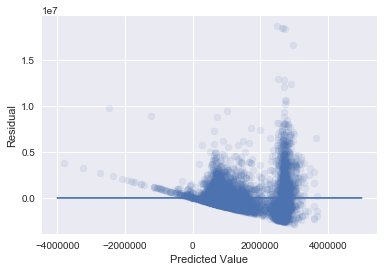

In [52]:
y_pred = results.predict(sm.add_constant(X))
plt.scatter(y_pred,y-y_pred,alpha=.1)
plt.plot(np.linspace(-4000000,5000000,10000),np.linspace(0,0,10000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

In [53]:
X=df_novol.loc[:,['Rating', 'review_count', '1Star', '2Star', '3Star', '4Star', '5Star',
       'style_count', 'days_since_launch', 'weight_ounces', 'min_price']]

y=df_novol['amazon_rank']

model = sm.OLS(y,sm.add_constant(X), missing="drop")
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amazon_rank   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     297.0
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        00:01:34   Log-Likelihood:            -1.4712e+05
No. Observations:                9303   AIC:                         2.943e+05
Df Residuals:                    9292   BIC:                         2.943e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.995e+06   3.85e+04     77.838      0.000    2.92e+06    3.07e+06
Rating            -4.398e+05   9212.220    -47.736      0.000   -4.58e+05   -4.22e+05
review_count      -1546.0698   1057.767     -1.462      0.144   -3619.525     527.386
1Star              -131.5662   6739.159     -0.020      0.984   -1.33e+04    1.31e+04
2Star             -1.439e+04   1.25e+04     -1.153      0.249   -3.89e+04    1.01e+04
3Star              4747.7131   9508.655      0.499      0.618   -1.39e+04    2.34e+04
4Star              1.022e+04   5956.361      1.716      0.086   -1456.640    2.19e+04
5Star             -1989.1640   1382.747     -1.439      0.150   -4699.651     721.323
style_count       -3.993e+04   4685.065     -8.524      0.000   -4.91e+04   -3.08e+04
days_since_launch   199.8890     21.756      9.188      0.000     157.242     242.536
weight_ounces     -1039.0850    116.708     -8.903      0.000   -1267.859    -810.311
min_price          -133.3381    156.014     -0.855      0.393    -439.159     172.483
==============================================================================
Omnibus:                     5126.297   Durbin-Watson:                   1.175
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            65770.305
Skew:                           2.377   Prob(JB):                         0.00
Kurtosis:                      15.127   Cond. No.                     4.65e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.55e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Text(0,0.5,'Residual')

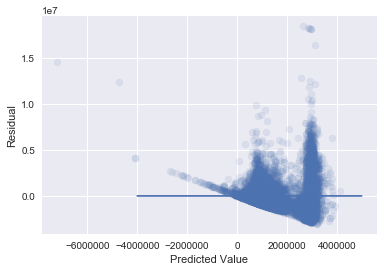

In [54]:
y_pred = results.predict(sm.add_constant(X))
plt.scatter(y_pred,y-y_pred,alpha=.1)
plt.plot(np.linspace(-4000000,5000000,10000),np.linspace(0,0,10000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

In [55]:
def add_square_terms(df):    
    
    df_poly = df.copy()
    
    for c in df.columns:
        df_poly[c + '**2'] = df[c]**2
        
    return df_poly

In [56]:
def RMSE(actual, predicted):
    return np.sqrt(mean_squared_error(actual,predicted))

In [57]:
#hold out 20% of the data for final testing
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10) 

#hold out 20% for validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [91]:
# Run on Linear Regression
lm = LinearRegression()
lm.fit(X_train, y_train)
print('OLS regression score val R^2: %.3f' % lm.score(X_val, y_val))
print('OLS regression score val RMSE: %.3f \n' % RMSE(lm.predict(X_val), y_val))

lm.fit(add_square_terms(X_train), y_train)
print('Squared terms regression val R^2: %.3f' 
      % lm.score(add_square_terms(X_val), y_val))
print('Squared terms regression score val RMSE: %.3f' 
      % RMSE(lm.predict(add_square_terms(X_val)), y_val))

OLS regression score val R^2: 0.247
OLS regression score val RMSE: 1777604.940 

Squared terms regression val R^2: 0.304
Squared terms regression score val RMSE: 1709181.702


In [92]:
lm.fit(add_square_terms(X), y)
print('Squared terms regression val R^2: %.3f' 
      % lm.score(add_square_terms(X_test), y_test))
print('Squared terms regression score test RMSE: %.3f' 
      % RMSE(lm.predict(add_square_terms(X_test)), y_test))

Squared terms regression val R^2: 0.284
Squared terms regression score test RMSE: 1711967.724


Text(0,0.5,'Residual')

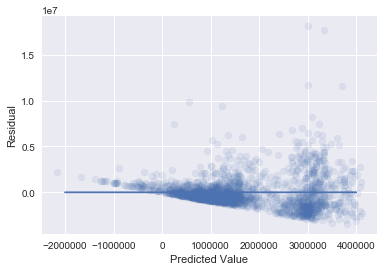

In [93]:
y_pred = lm.predict(add_square_terms(X_test))

plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(-2000000,4000000,10000),np.linspace(0,0,10000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

In [60]:
interactions = PolynomialFeatures(degree=2, interaction_only=True)

lm.fit(interactions.fit_transform(X_train), y_train)
print('OLS regression with interaction terms val R^2: %.3f' % lm.score(interactions.transform(X_val), y_val))
print('OLS regression with interaction terms val RMSE: %.3f' 
      % RMSE(lm.predict(interactions.fit_transform(X_val)), y_val))

OLS regression with interaction terms val R^2: 0.231
OLS regression with interaction terms val RMSE: 1797072.029


In [61]:
interactions = PolynomialFeatures(degree=2, interaction_only=False)

lm.fit(interactions.fit_transform(X_train), y_train)
print('OLS regression with interaction terms val R^2: %.3f' % lm.score(interactions.transform(X_val), y_val))
print('OLS regression with interaction terms val RMSE: %.3f' 
      % RMSE(lm.predict(interactions.fit_transform(X_val)), y_val))

OLS regression with interaction terms val R^2: 0.268
OLS regression with interaction terms val RMSE: 1752478.091


## Regularization and CV

In [62]:
from sklearn.model_selection import KFold


In [94]:

# Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

# this helps with the way kf will generate indices below
# Use X and not X_train because we're splitting again
arr_X = np.array(add_square_terms(X))
arr_y = np.array(y)


for train_ind, val_ind in kf.split(arr_X,arr_y):
    
    X_kf_train, y_kf_train = arr_X[train_ind], arr_y[train_ind]
    X_kf_val, y_kf_val = arr_X[val_ind], arr_y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_kf_train, y_kf_train)
    cv_lm_r2s.append(lm.score(X_kf_val, y_kf_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_kf_train)
    X_val_scaled = scaler.transform(X_kf_val)
    
    lm_reg.fit(X_train_scaled, y_kf_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_kf_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print('Simple mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_r2s),np.std(cv_lm_r2s)))
print('Ridge mean cv r^2: %.3f +- %.3f' %(np.mean(cv_lm_reg_r2s),np.std(cv_lm_reg_r2s)))

Simple regression scores:  [0.29948184242646336, -46.212056381151868, 0.29036206727390057, 0.28561567785528197, 0.31393875443597186]
Ridge scores:  [0.29941708953692669, -46.235600751974573, 0.29025524817491055, 0.28592782481725842, 0.31419282785605751] 

Simple mean cv r^2: -9.005 +- 18.604
Ridge mean cv r^2: -9.009 +- 18.613


In [64]:
# Just as terrible...

scaler = StandardScaler()
X_scaled = scaler.fit_transform(add_square_terms(X))
X_test_scaled = scaler.transform(add_square_terms(X_test))

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print('Ridge Regression test R^2: %.3f', lm_reg.score(X_test_scaled, y_test))

Ridge Regression test R^2: %.3f 0.283596719194


### Regularization with Alpha Testing

In [65]:
# alphalist = 10**(np.linspace(-3,4,500))

# err_vec_val_lasso = np.zeros(len(alphalist))
# err_vec_val_ridge = np.zeros(len(alphalist))
# err_vec_val_elastic = np.zeros(len(alphalist))
# err_vec_val_base = np.zeros(len(alphalist))

# for i, curr_alpha in enumerate(alphalist):
#     pipe_lasso = Pipeline([('standardize', StandardScaler()), ('lasso', Lasso(alpha = curr_alpha))])
#     pipe_ridge_lr = Pipeline([('standardize', StandardScaler()), ('ridge', Ridge(alpha = curr_alpha))])
#     pipe_elastic_lr = Pipeline([('standardize', StandardScaler()), ('elasticnet', ElasticNet(alpha = curr_alpha))])
#     pipe_base_lr = Pipeline([('standardize', StandardScaler()), ('linearregression', LinearRegression())])

#     total_error_lasso = 0
#     total_error_ridge = 0
#     total_error_elastic = 0
#     total_error_base = 0
    
#     for train_ind, val_ind in kf.split(arr_X, arr_y):
#         X_kf_train, y_kf_train = arr_X[train_ind], arr_y[train_ind]
#         X_kf_val, y_kf_val = arr_X[val_ind], arr_y[val_ind]
        
#         pipe_lasso.fit(X_kf_train, y_kf_train)
#         pipe_ridge_lr.fit(X_kf_train, y_kf_train)
#         pipe_elastic_lr.fit(X_kf_train, y_kf_train)
#         pipe_base_lr.fit(X_kf_train, y_kf_train)
        
#         val_pred_lasso = pipe_lasso.predict(X_kf_val)
#         val_pred_ridge = pipe_ridge_lr.predict(X_kf_val)
#         val_pred_elastic = pipe_elastic_lr.predict(X_kf_val)
#         val_pred_base = pipe_base_lr.predict(X_kf_val)
        
# #         test_error_lasso = np.sqrt(np.mean((val_pred_lasso - y_kf_val)**2))
# #         test_error_ridge = np.sqrt(np.mean((val_pred_ridge - y_kf_val)**2))
# #         test_error_elastic = np.sqrt(np.mean((val_pred_elastic - y_kf_val)**2))
# #         test_error_base = np.sqrt(np.mean((val_pred_base - y_kf_val)**2))

#         total_error_lasso += np.sqrt(np.mean((val_pred_lasso - y_kf_val)**2))
#         total_error_ridge += np.sqrt(np.mean((val_pred_ridge - y_kf_val)**2))
#         total_error_elastic += np.sqrt(np.mean((val_pred_elastic - y_kf_val)**2))
#         total_error_base += np.sqrt(np.mean((val_pred_base - y_kf_val)**2))
        
#     err_vec_val_lasso[i] = total_error_lasso
#     err_vec_val_ridge[i] = total_error_ridge
#     err_vec_val_elastic[i] = total_error_elastic
#     err_vec_val_base[i] = total_error_base

    
# # Print value of alpha with lowest error, and minimum error achieved on the test set across all alpha 
# print('Lasso: ', alphalist[np.argmin(err_vec_val_lasso)], ',', np.min(err_vec_val_lasso))
# print('Ridge: ', alphalist[np.argmin(err_vec_val_ridge)], ',', np.min(err_vec_val_ridge))
# print('ElasticNet: ', alphalist[np.argmin(err_vec_val_elastic)], ',', np.min(err_vec_val_elastic))
# print('LinearRegression: ', alphalist[np.argmin(err_vec_val_base)], ',', np.min(err_vec_val_base))

# best_alpha_lasso = alphalist[np.argmin(err_vec_val_lasso)]
# best_alpha_ridge = alphalist[np.argmin(err_vec_val_ridge)]
# best_alpha_elastic = alphalist[np.argmin(err_vec_val_elastic)]
# best_alpha_base = alphalist[np.argmin(err_vec_val_base)]


Lasso:  10,000.0 , 18,755,371.3512

Ridge:  3,557.15020682 , 8,999,775.43887

ElasticNet:  1.18071284667 , 8,999,777.10383

LinearRegression:  0.001 , 20,612,823.5657

_Lasso looks incomplete though, and there were bunch of errors so lets try it again with LassoCV_

In [66]:
## Data Scaling
std = StandardScaler()
std.fit(add_square_terms(X))

StandardScaler(copy=True, with_mean=True, with_std=True)

In [67]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(add_square_terms(X))
X_te = std.transform(add_square_terms(X_test))

In [68]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-3,6,200)

lr_model8 = LassoCV(alphas = alphavec, cv=5)
lr_model8.fit(X_tr,y)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


LassoCV(alphas=array([  1.00000e-03,   1.10975e-03, ...,   9.01102e+05,   1.00000e+06]),
    copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
    n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [69]:
# This is the best alpha value it found
lr_model8.alpha_

6080.2242616494268

In [70]:
list(zip(add_square_terms(X).columns,lr_model8.coef_))

[('Rating', -2402178.9449399388),
 ('review_count', -0.0),
 ('1Star', 29098.299671169279),
 ('2Star', 0.0),
 ('3Star', -0.0),
 ('4Star', 0.0),
 ('5Star', -361469.31646006595),
 ('style_count', -314886.94200463226),
 ('days_since_launch', 557210.00642629166),
 ('weight_ounces', -458083.38471404131),
 ('min_price', 41709.103415830024),
 ('Rating**2', 1486880.9245926924),
 ('review_count**2', 0.0),
 ('1Star**2', 21442.302443178072),
 ('2Star**2', 0.0),
 ('3Star**2', -22090.440649628334),
 ('4Star**2', -0.0),
 ('5Star**2', 228504.66749378605),
 ('style_count**2', 190000.58057040151),
 ('days_since_launch**2', -343440.64288626565),
 ('weight_ounces**2', 377019.57790242351),
 ('min_price**2', 20840.8016698229)]

In [71]:
# Make predictions on the test set using the new model
test_set_pred8 = lr_model8.predict(X_te)

In [72]:
lr_model8.score(X_te, y_test)

0.28292881793626223

In [73]:
np.sqrt(np.mean((test_set_pred8 - y_test)**2))

1712673.0862650704

In [74]:
## Note: lars_path takes numpy matrices, not pandas dataframes

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso', verbose=True)

Computing regularization path using the LARS ...
.

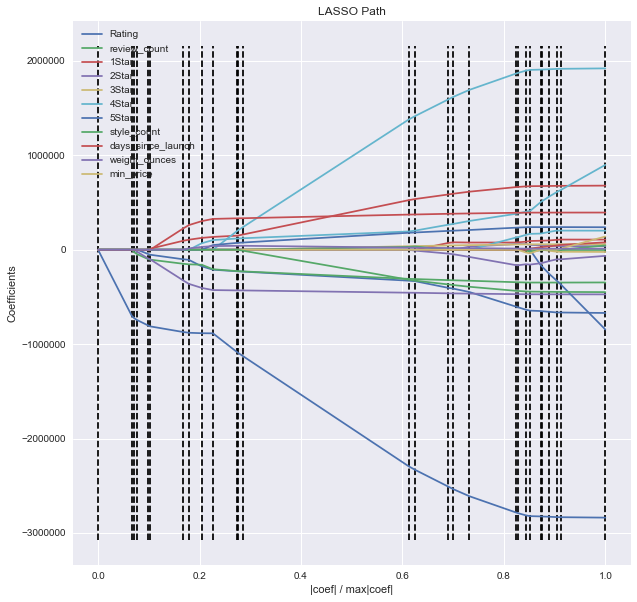

In [75]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

In [76]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

rf = RandomForestRegressor(n_estimators=1800, max_features=3)
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.41758518556592328

Text(0,0.5,'Residual')

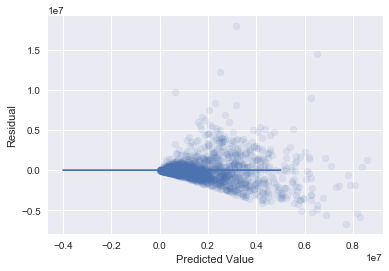

In [77]:
y_pred = rf.predict(X_test)
plt.scatter(y_pred,y_test-y_pred,alpha=.1)
plt.plot(np.linspace(-4000000,5000000,10000),np.linspace(0,0,10000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')


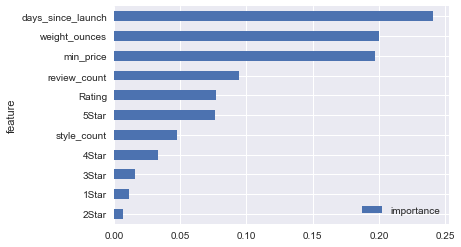

In [78]:
feat_imps = list(zip(X_train.columns,rf.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])

feat_imps.plot(x='feature',y='importance',kind='barh')

In [79]:
rf.score(X_test, y_test)

0.38679979300049094